In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

#!pip install -q tensorflow-gpu == 2.0.0-beta1

import tensorflow as tf

#tf.enable_eager_execution()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

print("GPU Available: ", tf.test.is_gpu_available())

GPU Available:  True


In [7]:
# Download data
#path_to_zip = tf.keras.utils.get_file(
#    'cmn-eng.zip', origin = 'http://storage.googleapis.com/download.tensorflow.org/data/cmn-eng.zip', extract = True)

path_to_file = '/home/sixianzhang/Documents/Data/cmn-eng/cmn.txt'

In [3]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [4]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [5]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding = 'UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]
    
    return zip(*word_pairs)

In [16]:
en, sp = create_dataset(path_to_file, None)
print(en[1])
print(sp[1].decode())

<start> hi . <end>


AttributeError: 'str' object has no attribute 'decode'

In [7]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [8]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters = '')
    lang_tokenizer.fit_on_texts(lang)
    
    tensor = lang_tokenizer.texts_to_sequences(lang)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                         padding = 'post')
    return tensor, lang_tokenizer

In [9]:
def load_dataset(path, num_examples = None):
    targ_lang, inp_lang = create_dataset(path, num_examples)
    
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [10]:
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [11]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size = 0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [12]:
def convert(lang, tensor):
    for t in tensor:
        if t!= 0:
            print("%d -------> %s" % (t, lang.index_word[t]))

In [13]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 -------> <start>
6 -------> ¿
23 -------> te
40 -------> gusta
16 -------> esta
501 -------> cancion
5 -------> ?
2 -------> <end>

Target Language; index to word mapping
1 -------> <start>
22 -------> do
6 -------> you
35 -------> like
20 -------> that
529 -------> song
7 -------> ?
2 -------> <end>


In [14]:
# Create TF dataset
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [16]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units,batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                      return_sequences = True, 
                                      return_state = True,
                                      recurrent_initializer = 'glorot_uniform')
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialization_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [17]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialization_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [18]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))
        
        attention_weights = tf.nn.softmax(score, axis = 1)
        
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis = 1)
        
        return context_vector, attention_weights

In [19]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [20]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, 
                                      return_sequences = True,
                                      return_state = True,
                                      recurrent_initializer = 'glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.dec_units)
    
    def call(self, x, hidden, enc_output):
        
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        x = self.embedding(x)
        
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
        
        output, state = self.gru(x)
        
        output = tf.reshape(output, (-1, output.shape[2]))
        
        x = self.fc(output)
        
        return x, state, attention_weights

In [21]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _ , _ = decoder(tf.random.uniform((64,1)), sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits = True, reduction = 'none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype = loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer = optimizer, 
                                encoder = encoder, 
                                decoder = decoder)

In [24]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        
        # Teacher Forcing
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            loss += loss_function(targ[:, t], predictions)
            
            dec_input = tf.expand_dims(targ[:,t], 1)
        
    batch_loss = (loss/ int(targ.shape[1]))
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, variables)
    
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [25]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    enc_hidden = encoder.initialization_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))

    if (epoch + 1) % 2  == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.4091
Epoch 1 Batch 100 Loss 2.1802
Epoch 1 Batch 200 Loss 1.9291
Epoch 1 Batch 300 Loss 1.7340
Epoch 1 Loss 2.0373
Time taken for 1 epoch 140.5543315410614 sec

Epoch 2 Batch 0 Loss 1.5958
Epoch 2 Batch 100 Loss 1.4880
Epoch 2 Batch 200 Loss 1.4319
Epoch 2 Batch 300 Loss 1.3006
Epoch 2 Loss 1.3891
Time taken for 1 epoch 117.99223160743713 sec

Epoch 3 Batch 0 Loss 1.1292
Epoch 3 Batch 100 Loss 1.0035
Epoch 3 Batch 200 Loss 1.0363
Epoch 3 Batch 300 Loss 0.9641
Epoch 3 Loss 0.9798
Time taken for 1 epoch 117.34747695922852 sec

Epoch 4 Batch 0 Loss 0.7986
Epoch 4 Batch 100 Loss 0.6318
Epoch 4 Batch 200 Loss 0.7506
Epoch 4 Batch 300 Loss 0.6453
Epoch 4 Loss 0.6694
Time taken for 1 epoch 118.16437649726868 sec

Epoch 5 Batch 0 Loss 0.5233
Epoch 5 Batch 100 Loss 0.3868
Epoch 5 Batch 200 Loss 0.5347
Epoch 5 Batch 300 Loss 0.4313
Epoch 5 Loss 0.4523
Time taken for 1 epoch 117.41580581665039 sec

Epoch 6 Batch 0 Loss 0.3369
Epoch 6 Batch 100 Loss 0.2546
Epoch 6 Batch 200 

In [26]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [27]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [28]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [29]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


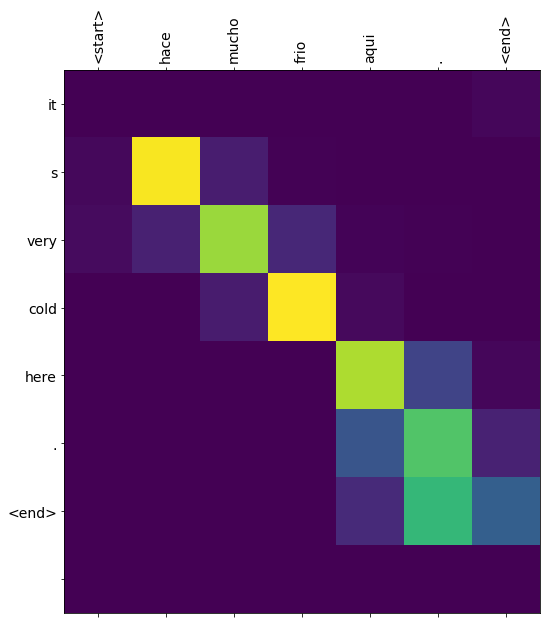

In [30]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


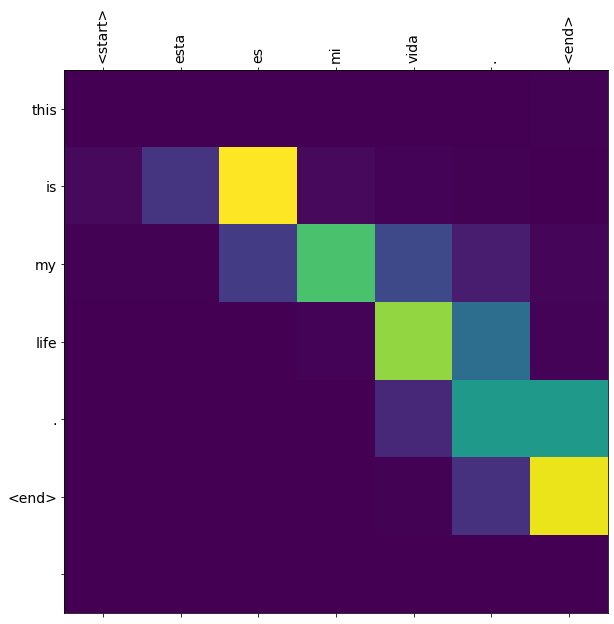

In [31]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


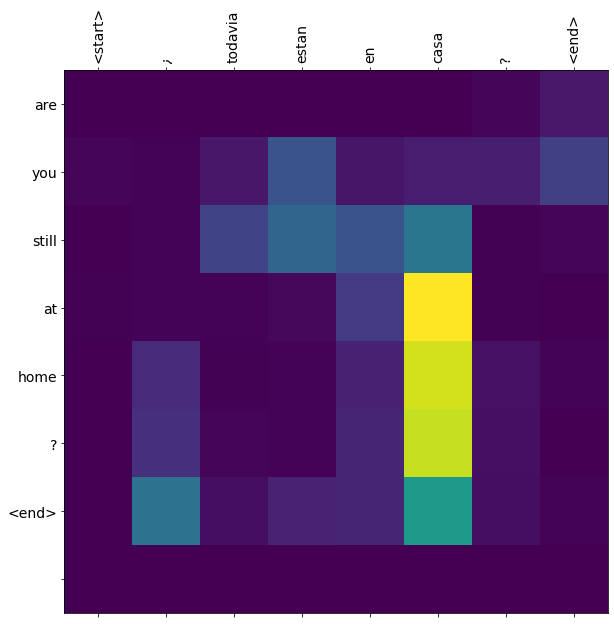

In [32]:
translate(u'¿todavia estan en casa?')

Input: <start> adios . <end>
Predicted translation: we heard him . <end> 


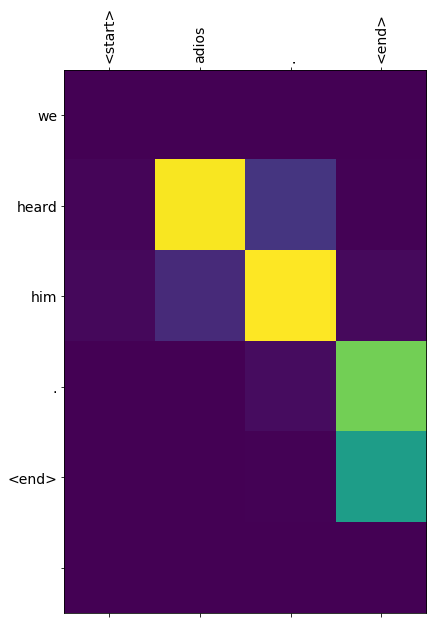

In [33]:
translate(u'adiós.')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


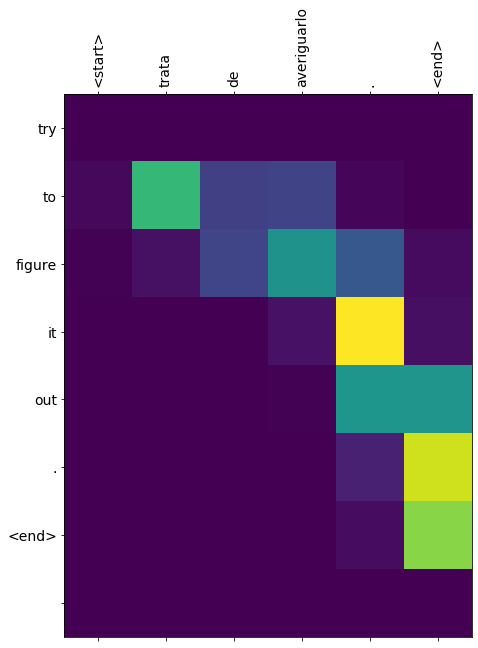

In [34]:
translate(u'trata de averiguarlo.')

In [35]:
print("GPU Available: ", tf.test.is_gpu_available())

GPU Available:  True


In [36]:
import sys
sys.version

'3.6.8 (default, Jan 14 2019, 11:02:34) \n[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]'

Input: <start> hola . <end>
Predicted translation: hello ! <end> 


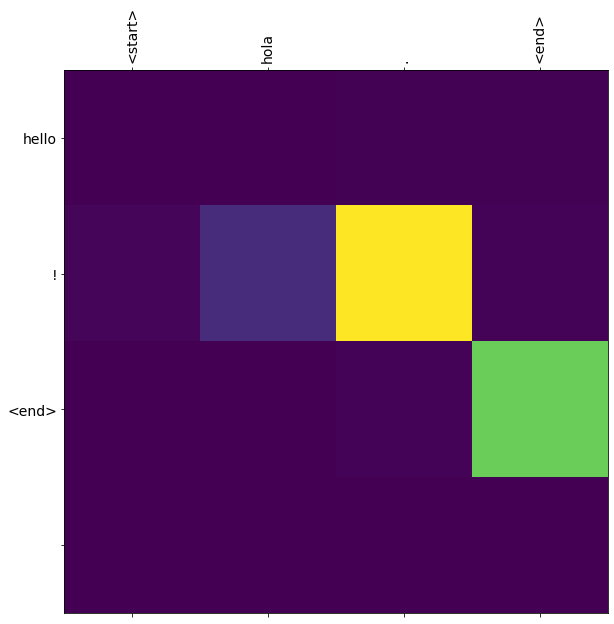

In [37]:
translate(u'hola.')